<a id='top'></a>
# BERT & Pytorch-Lightning Baseline Training

Thank you for your checking this notebook.

This is my baseline of training model for "Feedback Prize - Evaluating Student Writing" competition [Link](https://www.kaggle.com/c/feedback-prize-2021/overview).

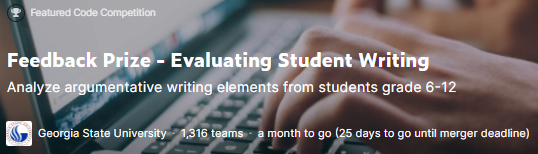


Actually this is the first time for me to work on Named Entity Recognition(NER) task.

So there are still a lot of room to improve this baseline.

I am really appreciate your question, feedback and upvote :) 

Notebook for prediction & submittion is still under preparation. Link will be add here afterwards.

## Contents
1. [Set config and load data](#config)
2. [Preprocessing](#preproces)
3. [Create dataset](#dataset)
4. [Define model](#define)
5. [Finetuning pre-trained model](#train)
6. [Validation](#cv)
7. [Conclution](#conclution)
8. [Reference](#ref)

<a id='config'></a>

---
### Set config and load data
---

[Back to top](#top)

In [ ]:
DEBUG = False
pathTrainInfo = '../input/feedback-prize-2021/train.csv'
pathTrainData = '../input/feedback-prize-2021/train'
MODEL_NAME = 'bert-base-uncased'

In [ ]:
# === General ===
import sys, warnings, time, os,copy
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
import random
import pprint
from pathlib import Path

# === Modelling ===
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report
import glob
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForTokenClassification
import pytorch_lightning as pl
import itertools

<a id='preproces'></a>

---
### Preprocessing
---

[Back to top](#top)

In [ ]:
dfTrainInfo = pd.read_csv(pathTrainInfo)
dfTrainInfo

In [ ]:
# Check valiation of "discourse_type"
listType = list(dfTrainInfo['discourse_type'].unique())
print(f'discourese_type are {listType}. \n')
dfTrainInfo['discourse_type'].value_counts().plot.bar()

In [ ]:
typeDict = {
    'Lead': 1,
    'Position': 2,
    'Evidence': 3,
    'Claim': 4,
    'Concluding Statement': 5,
    'Counterclaim': 6,
    'Rebuttal': 7
}

In [ ]:
def data_sampling(df, rate=0.3):
    '''Sampling data with receving rate'''

    df = df.groupby('discourse_type', as_index=False)
    df = df.apply(lambda x: x.sample(n=int(len(x)*rate), random_state=37))
    df = df.reset_index(drop=True)
    df = df.sample(frac=1, random_state=0)

    return df

In [ ]:
if DEBUG:
    dfTrainInfo = data_sampling(dfTrainInfo, rate=0.01)
dfTrainInfo   

In [ ]:
dfTrainInfo['discourse_type'].value_counts().plot.bar()

Below grouping of train labels by text file was learn from this notebook [Feedback Prize HuggingFace Baseline: Training by DAREK KŁECZEK](https://www.kaggle.com/thedrcat/feedback-prize-huggingface-baseline-training). Thank you!

In [ ]:
path = Path(pathTrainData)

def get_raw_text(ids):
    with open(path/f'{ids}.txt', 'r') as file: data = file.read()
    return data

In [ ]:
if DEBUG:
    print(get_raw_text('423A1CA112E2'))

In [ ]:
df1 = dfTrainInfo.groupby('id')['discourse_type'].apply(list).reset_index(name='classlist')
df2 = dfTrainInfo.groupby('id')['discourse_start'].apply(list).reset_index(name='starts')
df3 = dfTrainInfo.groupby('id')['discourse_end'].apply(list).reset_index(name='ends')
df4 = dfTrainInfo.groupby('id')['predictionstring'].apply(list).reset_index(name='predictionstrings')
df5 = dfTrainInfo.groupby('id')['discourse_text'].apply(list).reset_index(name='discourse_text')

dfTrainInfo = pd.merge(df1, df2, how='inner', on='id')
dfTrainInfo = pd.merge(dfTrainInfo, df3, how='inner', on='id')
dfTrainInfo = pd.merge(dfTrainInfo, df4, how='inner', on='id')
dfTrainInfo = pd.merge(dfTrainInfo, df5, how='inner', on='id')
dfTrainInfo['text'] = dfTrainInfo['id'].apply(get_raw_text)

dfTrainInfo

In [ ]:
if DEBUG:
    dfTrainInfo['classlist'].value_counts().plot.bar()

<a id='dataset'></a>

---
### Create dataset
---

[Back to top](#top)

In [ ]:
# Create dataset
dataset = []
data = {}

for i in range(dfTrainInfo.shape[0]):
    data['curid'] = dfTrainInfo.loc[i, 'id']
    entities = []
    for j in range(len(dfTrainInfo.loc[i, 'predictionstrings'])):
        k = int(dfTrainInfo.loc[i, 'predictionstrings'][j].split()[-1])
        if k > 500:
            # ignore the named text after position 500 because of limitation of input data length, 512.
            continue
        else:
            entities.append({'name': dfTrainInfo.loc[i, 'discourse_text'][j],
                            'span': [int(dfTrainInfo.loc[i, 'predictionstrings'][j].split()[0]), int(dfTrainInfo.loc[i, 'predictionstrings'][j].split()[-1])+1],
                            'type': dfTrainInfo.loc[i, 'classlist'][j]})
    data['entities'] = entities
    data['text'] = " ".join(dfTrainInfo.loc[i, 'text'].split())
    data2 = copy.copy(data)
    dataset.append(data2)
            

In [ ]:
if DEBUG:
    pprint.pprint(dataset[:5])

In [ ]:
# Convert type to type ID
for sample in dataset:
    for e in sample["entities"]:
        e['type_id'] = typeDict[e['type']]
        del e['type']

# Split dataset
random.shuffle(dataset)
n = len(dataset)
n_train = int(n*0.6)
n_val = int(n*0.2)
dataset_train = dataset[:n_train]
dataset_val = dataset[n_train:n_train+n_val]
dataset_test = dataset[n_train+n_val:]

In [ ]:
if DEBUG:
    pprint.pprint(dataset_train[:3])

In [ ]:
class NER_tokenizer(BertTokenizer):
       
    def encode_plus_tagged(self, text, entities, max_length):
        """
        When receiving text & entities, return encoding.
        """
        entities = sorted(entities, key=lambda x: x['span'][0])
        splitted = [] 
        position = 0
        for entity in entities:
            start = entity['span'][0]
            end = entity['span'][1]
            label = entity['type_id']
            # assign 0 for non-named
            splitted.append({'text':text[position:start], 'label':0}) 
            # assign label for named
            splitted.append({'text':text[start:end], 'label':label}) 
            position = end
        splitted.append({'text': text[position:], 'label':0})
        splitted = [ s for s in splitted if s['text'] ] # ignore length == 0

        # Convert to token and add labels
        tokens = [] 
        labels = [] 
        for text_splitted in splitted:
            text = text_splitted['text']
            label = text_splitted['label']
            tokens_splitted = self.tokenize(text)
            labels_splitted = [label] * len(tokens_splitted)
            tokens.extend(tokens_splitted)
            labels.extend(labels_splitted)

        # Encode to input for BERT
        input_ids = self.convert_tokens_to_ids(tokens)
        encoding = self.prepare_for_model(
            input_ids, 
            max_length=max_length, 
            padding='max_length', 
            truncation=True
        ) # convert input_ids to encoding
        # Special token [CLS]、[SEP] -> label=0
        labels = [0] + labels[:max_length-2] + [0] 
        # Special token [PAD] -> label=0
        labels = labels + [0]*( max_length - len(labels) ) 
        encoding['labels'] = labels

        return encoding

    def encode_plus_untagged(self, text, max_length=None, return_tensors=None):
        """
        Convert text to token and record position of each token in original text.
        """
        tokens_original = [] 
        words = self.tokenize(text)
        tokens_original.extend([token.replace('##','') for token in words])

        # Check position of each token in original text
        position = 0
        countEnd = 0
        spans = [] 
        for token in tokens_original:
            
            l = len(token)
            while 1:
                positionStart = position
                if token != text[position:position+l].lower():
                    if position+l > len(text):
                        countEnd += 1
                        position = positionStart
                        # print(f'reached end. {countEnd}')
                        break
                    else:
                        position += 1
                else:
                    spans.append([position, position+l])
                    position += l
                    break
        
        # print(f'share of not match {countEnd / len(tokens_original)}')

        # Encode to input for BERT
        input_ids = self.convert_tokens_to_ids(tokens_original) 
        encoding = self.prepare_for_model(
            input_ids, 
            max_length=max_length, 
            padding='max_length' if max_length else False, 
            truncation=True if max_length else False
        )
        sequence_length = len(encoding['input_ids'])
        # Add dummy span for [CLS]
        spans = [[-1, -1]] + spans[:sequence_length-2] 
        # Add dummy span for [SEP]、[PAD]
        spans = spans + [[-1, -1]] * ( sequence_length - len(spans) ) 

        # If necessary convert to torch.Tensor
        if return_tensors == 'pt':
            encoding = { k: torch.tensor([v]) for k, v in encoding.items() }

        return encoding, spans

    def convert_bert_output_to_entities(self, text, labels, spans):
        """
        Get named text based on text, prediction of label & position of each token
        """
        # remove position for special token from labels, spans
        labels = [label for label, span in zip(labels, spans) if span[0] != -1]
        spans = [span for span in spans if span[0] != -1]

        # Concate tokens which have same lavel in sequence and get named text
        entities = []
        for label, group in itertools.groupby(enumerate(labels), key=lambda x: x[1]):
            
            group = list(group)
            start = spans[group[0][0]][0]
            end = spans[group[-1][0]][1]

            if label != 0: 
                entity = {
                    "name": text[start:end],
                    "span": [start, end],
                    "type_id": label
                }
                entities.append(entity)

        return entities

In [ ]:
tokenizer = NER_tokenizer.from_pretrained(MODEL_NAME)

In [ ]:
if DEBUG:
    pprint.pprint(dataset_train[1])

In [ ]:
if DEBUG:
    text = dataset_train[1]['text']
    entities = dataset_train[1]['entities']

    encoding = tokenizer.encode_plus_tagged(text, entities, max_length=512)
    print(encoding)

In [ ]:
if DEBUG:
    encoding, spans = tokenizer.encode_plus_untagged(text, max_length = 128, return_tensors='pt')
    print('# encoding')
    print(encoding)
    print('# spans')
    print(spans)

In [ ]:
def create_dataset(tokenizer, dataset, max_length):
    """
    Convert dataset to dataloarder
    """
    dataset_for_loader = []
    for sample in dataset:
        if len(sample['entities']) ==0:
            continue
        else:
            text = sample['text']
            entities = sample['entities']
            encoding = tokenizer.encode_plus_tagged(
                text, entities, max_length=max_length
            )
        encoding = { k: torch.tensor(v) for k, v in encoding.items() }
        dataset_for_loader.append(encoding)
    return dataset_for_loader

In [ ]:
# データセットの作成
if DEBUG:
    max_length = 128
    batch_size = 32
else:
    max_length = 512
    batch_size = 5
    
dataset_train_for_loader = create_dataset(tokenizer, dataset_train, max_length)
dataset_val_for_loader = create_dataset(tokenizer, dataset_val, max_length)

# データローダの作成
dataloader_train = DataLoader(dataset_train_for_loader, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val_for_loader, batch_size=batch_size)

<a id='define'></a>

---
### Define model
---

[Back to top](#top)

In [ ]:
class BertForTokenClassification_pl(pl.LightningModule):
        
    def __init__(self, model_name, num_labels, lr):
        super().__init__()
        self.save_hyperparameters()
        self.bert_tc = BertForTokenClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )
        
    def training_step(self, batch, batch_idx):
        output = self.bert_tc(**batch)
        loss = output.loss
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        output = self.bert_tc(**batch)
        val_loss = output.loss
        self.log('val_loss', val_loss)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_weights_only=True,
    dirpath='model/'
)

trainer = pl.Trainer(
    gpus=1,
    max_epochs=9,
    callbacks=[checkpoint]
)

<a id='train'></a>

---
### Finetuning pre-trained model
---

[Back to top](#top)

In [ ]:
# fine tuning
model = BertForTokenClassification_pl(MODEL_NAME, num_labels=8, lr=1e-5)
trainer.fit(model, dataloader_train, dataloader_val)
best_model_path = checkpoint.best_model_path

In [ ]:
# Load best model
model = BertForTokenClassification_pl.load_from_checkpoint(
    best_model_path
    ) 

# Save  model
model.bert_tc.save_pretrained('fbp001')

del model, trainer
torch.cuda.empty_cache()

<a id='cv'></a>

---
### Validation
---

[Back to top](#top)

In [ ]:
def predict(text, tokenizer, bert_tc):
    """
    NER Prediction by BERT
    """
    # encoding
    encoding, spans = tokenizer.encode_plus_untagged(
        text, max_length=512, return_tensors='pt'
    )
    encoding = { k: v.cuda() for k, v in encoding.items() }

    # prediction
    with torch.no_grad():
        output = bert_tc(**encoding)
        scores = output.logits
        labels_predicted = scores[0].argmax(-1).cpu().numpy().tolist() 
     
    # convert labels to named texts
    entities = tokenizer.convert_bert_output_to_entities(
        text, labels_predicted, spans
    )

    return entities

In [ ]:
# Load saved model
pathModel = './fbp001'
bert_tc = BertForTokenClassification.from_pretrained(pathModel, num_labels=8)
bert_tc = bert_tc.cuda()

# Prediction by finetuned model
entities_list = [] 
entities_predicted_list = [] 
for sample in tqdm(dataset_test):
    text = sample['text']
    entities_predicted = predict(text, tokenizer, bert_tc) 
    entities_list.append(sample['entities'])
    entities_predicted_list.append( entities_predicted )

In [ ]:
if DEBUG:
    pprint.pprint(entities_list[:5])
    print('-'*50)
    pprint.pprint(entities_predicted_list[:5])

In [ ]:
if DEBUG:
    print("Correct:")
    print(entities_list[0])
    print("Prediction")
    print(entities_predicted_list[0])

In [ ]:
def evaluate_model(entities_list, entities_predicted_list, type_id=None):
    """
    Calcurate presision, recall & F value.
    """
    num_entities = 0 # num of named text
    num_predictions = 0 # num of predictions
    num_correct = 0 # num of correct predictions

    # correct if position in text and ID are match.
    for entities, entities_predicted in zip(entities_list, entities_predicted_list):

        if type_id:
            entities = [ e for e in entities if e['type_id'] == type_id ]
            entities_predicted = [ 
                e for e in entities_predicted if e['type_id'] == type_id
            ]
            
        get_span_type = lambda e: (e['span'][0], e['span'][1], e['type_id'])
        set_entities = set( get_span_type(e) for e in entities )
        set_entities_predicted = set( get_span_type(e) for e in entities_predicted )

        num_entities += len(entities)
        num_predictions += len(entities_predicted)
        num_correct += len( set_entities & set_entities_predicted )

    precision = num_correct/num_predictions
    recall = num_correct/num_entities
    f_value = 2*precision*recall/(precision+recall)

    result = {
        'num_entities': num_entities,
        'num_predictions': num_predictions,
        'num_correct': num_correct,
        'precision': precision,
        'recall': recall,
        'f_value': f_value
    }

    return result

In [ ]:
print( evaluate_model(entities_list, entities_predicted_list) )

<a id='conclution'></a>

---
### Conclution

The validation score was still not good enough. 
It means there might be a lot of potential to improve. 

As 1st step, I used BERT for classification. 
That bottleneck was max length of input data, 512.
So I sampled only the named taxt before position 500 in original text. 

Next approach would be to use that data after position 500. 
I also have intersting to use other BERT models. 

If you have any advice for me, please leave it in comment field!

---

[Back to top](#top)

<a id='ref'></a>

---
### Reference


- [stockmarkteam/bert-book Chapter.8](https://github.com/stockmarkteam/bert-book/blob/master/Chapter8.ipynb) : The Japanese book about NLP with BERT. It is quite useful for beginner like me.


---

[Back to top](#top)